<font color=blue size=6>**ANNOTATION:**</font>

<font size=5>The notebook presents CNN model, which has demonstrated one of the best score on MNIST dataset. The layers of Batch Normalizarion also added. Model uses annealing algorithm to improve accuracy.
Data augmentation is used.</font>

<h1>MNIST_Recognizer_CNN<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Cheating-with-full-MNIST-dataset" data-toc-modified-id="Cheating-with-full-MNIST-dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Cheating with full MNIST dataset</a></span></li><li><span><a href="#Split-into-Target-and-Features" data-toc-modified-id="Split-into-Target-and-Features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split into Target and Features</a></span></li><li><span><a href="#Check-for-null-and-missing-values" data-toc-modified-id="Check-for-null-and-missing-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check for null and missing values</a></span></li><li><span><a href="#Normalize-data" data-toc-modified-id="Normalize-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Normalize data</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Reshape</a></span></li><li><span><a href="#Encode-target" data-toc-modified-id="Encode-target-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Encode target</a></span></li><li><span><a href="#Split-into-train-and-validation-set" data-toc-modified-id="Split-into-train-and-validation-set-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Split into train and validation set</a></span></li><li><span><a href="#Data-vizualization" data-toc-modified-id="Data-vizualization-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Data vizualization</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Training-and-validation-curves" data-toc-modified-id="Training-and-validation-curves-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training and validation curves</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Explore-the-errors" data-toc-modified-id="Explore-the-errors-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Explore the errors</a></span></li><li><span><a href="#Visualising-Convolution-Layers" data-toc-modified-id="Visualising-Convolution-Layers-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Visualising Convolution Layers</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

# Importing libraries

In [3]:
#Basic (used in the most of the projects)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#To show figure just in notebook under the code cell
%matplotlib inline 
sns.set(style='white', context='notebook', palette='deep')

#For repeatability of results
np.random.seed(9) 

In [4]:
#Specific (are likely to be used in this project)

import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf

from keras.utils.np_utils import to_categorical #convert to one-hot-encoding
from keras.models import Sequential, Model #It is important to import Model from keras, not from tf.keras, otherwise there will be a conflict
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.


In [5]:
#GPU testing 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.test.is_built_with_cuda())

Default GPU Device: /device:GPU:0
True


# Data Preparation 

## Load data 

In [93]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## Cheating with full MNIST dataset

In [91]:
from keras.datasets import mnist

(X_train,y_train),(X_test,y_test)=mnist.load_data()
X_cheat_train=np.vstack((X_train,X_test))
y_cheat_train=np.concatenate([y_train,y_test])
X_cheat_train =X_cheat_train/255
X_cheat_train=X_cheat_train.reshape(-1,28,28,1)
print(X_cheat_train.shape,y_cheat_train.shape)

(70000, 28, 28, 1) (70000,)


In [109]:
y_cheat_train=to_categorical(y_cheat_train,num_classes=10)

## Split into Target and Features

In [94]:
y_train=train['label']
X_train=train.drop(columns='label')

In [95]:
#Free memory
del train

Check balance in the target varible:

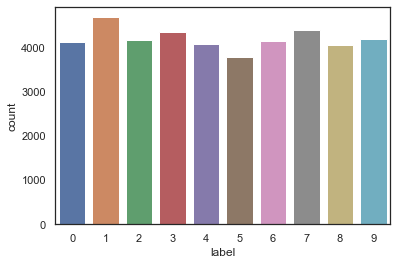

In [96]:
sns.countplot(y_train)

The dataset is balanced.

## Check for null and missing values

In [97]:
X_train.isna().any().sum()

0

In [98]:
test.isna().any().sum()

0

## Normalize data

In [99]:
X_train /=255.0
test /=255.0

## Reshape

In [100]:
#As we have X_train as 1D-vector we need to reshape it for enter to convolutional layer of NN
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

print(X_train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


## Encode target

In [101]:
#Cross-entropy loss function needs OHE for target
y_train=to_categorical(y_train,num_classes=10)

## Split into train and validation set

In [102]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size = 0.1, random_state=2)

## Data vizualization

(-0.5, 27.5, 27.5, -0.5)

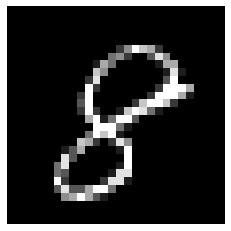

In [103]:
#1st digit
plt.imshow(X_train[0][:,:,0],cmap='gray')
plt.axis('off')

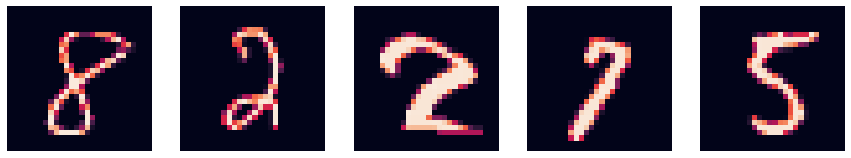

In [26]:
#5 random digits

from random import randrange

fig=plt.figure(figsize=(15,10))
columns=5
rows=1
for i in range(columns*rows):
    fig.add_subplot(rows,columns,i+1)
    plt.imshow(X_train[randrange(len(X_train))][:,:,0])
    plt.axis('off')


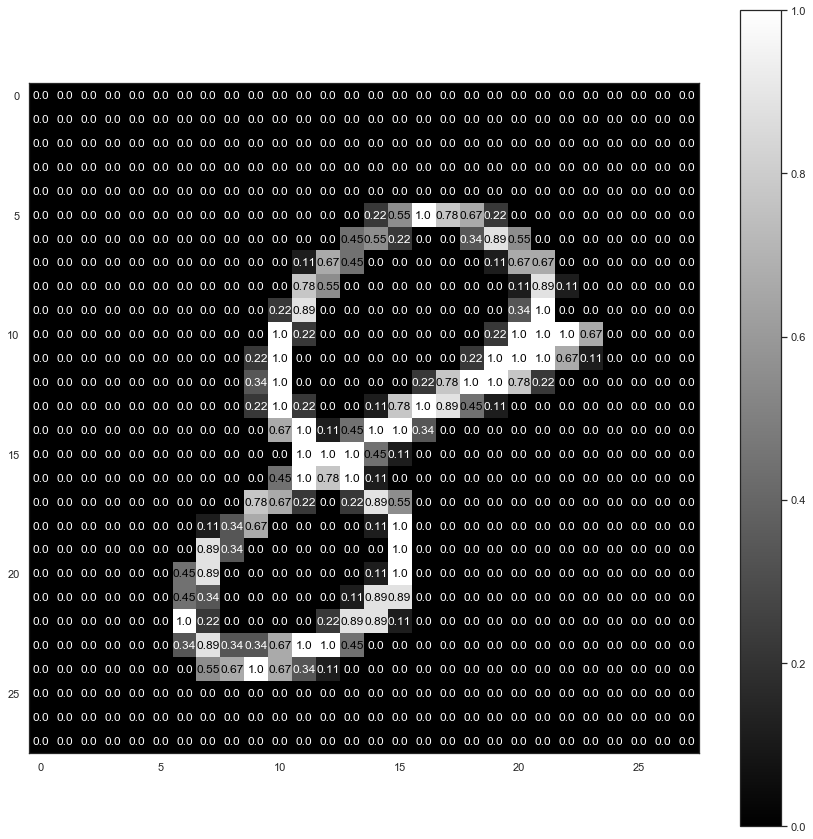

In [27]:
#Vizualizing grayscale

def visualize_input(img,ax):
    pos=ax.imshow(img,cmap='gray')
    width,height=img.shape
    thresh = img.max()/2.5
    for x in range (width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<=thresh else 'black')
    plt.colorbar(pos)          

fig=plt.figure(figsize=(15,15))
ax=fig.add_subplot()
visualize_input(X_train[0].reshape(28,28),ax)   
  

# Modeling

## Define the model

In [28]:
#Sequential model
model=Sequential()

# 2 convolutional layers, BatchNormalization, 1 subsampling layer, 1 regularization layer
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 convolutional layers with 64 filters, BatchNormalization, 1 subsampling layer, 1 regularization layer
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Classification layers
model.add(Flatten())  #Full conected layer needs 1D array on input
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))



In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

In [30]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) 
#lr - learning rate, rho - Discounting factor for the history/coming gradient, epsilon - is added in formula for numerical stability, decay - decreasing of lr 

In [31]:
# Compile the model
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=['accuracy'] )

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [32]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [33]:
batch_size = 86

## Data augmentation

In [25]:
# Without data augmentation:
#history = model.fit(X_train, y_train, batch_size = batch_size, epochs = 15, validation_data = (X_val, y_val), verbose = 2)

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 92s - loss: 0.1606 - accuracy: 0.9516 - val_loss: 1.4640 - val_accuracy: 0.6207


In [107]:
# With data augmentation to prevent overfitting:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_cheat_train)

In [110]:
#I set the number of epochs=16, because after that val_loss is not decrising 
history = model.fit_generator(datagen.flow(X_cheat_train,y_cheat_train, batch_size=batch_size),
                              epochs = 25, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_cheat_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/25
 - 157s - loss: 0.0274 - accuracy: 0.9919 - val_loss: 0.0117 - val_accuracy: 0.9964
Epoch 2/25
 - 156s - loss: 0.0265 - accuracy: 0.9923 - val_loss: 0.0110 - val_accuracy: 0.9967
Epoch 3/25
 - 156s - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0103 - val_accuracy: 0.9962
Epoch 4/25
 - 156s - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0084 - val_accuracy: 0.9971
Epoch 5/25
 - 156s - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0.0074 - val_accuracy: 0.9969
Epoch 6/25
 - 157s - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0097 - val_accuracy: 0.9967
Epoch 7/25
 - 156s - loss: 0.0233 - accuracy: 0.9932 - val_loss: 0.0107 - val_accuracy: 0.9964

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 8/25
 - 156s - loss: 0.0216 - accuracy: 0.9934 - val_loss: 0.0067 - val_accuracy: 0.9979
Epoch 9/25
 - 156s - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0070 - val_accuracy: 0.9981
Epoch 10/25
 - 156s - loss: 0.0184 - accuracy: 0.9945 - val_loss

# Evaluation 

## Training and validation curves

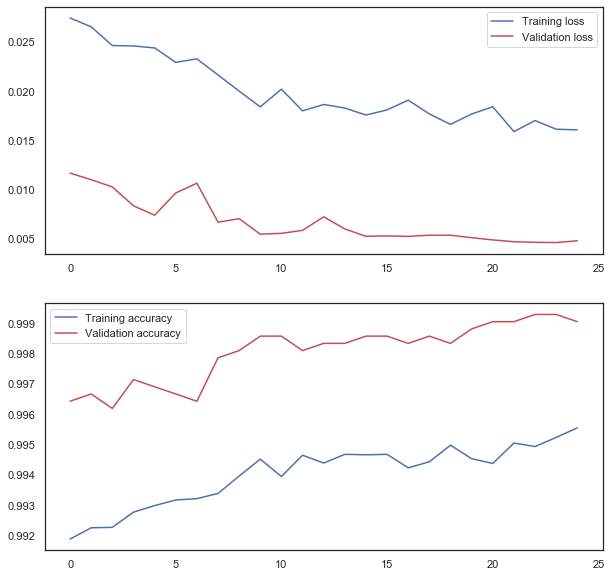

In [111]:
fig,ax=plt.subplots(2,figsize=(10,10))

ax[0].plot(history.history['loss'],color='b',label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend(loc='best')

## Confusion matrix

In [112]:
# Predict the values from the validation dataset
y_pred=model.predict(X_val)

In [113]:
# Convert one hot vectors to predicted classes
y_pred_classes = np.argmax(y_pred,axis = 1)
# Convert one hot vectors to validation classes
y_true = np.argmax(y_val,axis = 1) 

#Accuracy on validation set
accuracy=tf.keras.metrics.Accuracy()
accuracy.update_state(y_true, y_pred_classes)
print('Validation accuracy:', round(float(accuracy.result()),2))

Validation accuracy: 1.0


In [114]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

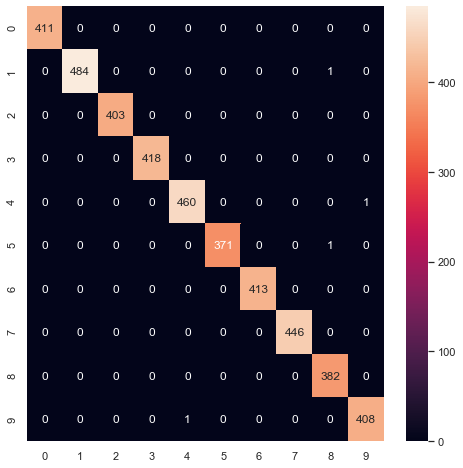

In [115]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_mtx,annot=True, fmt='d')

'4' is the most difficult case)

## Explore the errors

[694, 1104, 2614, 3052]


Text(0.5, 0.5, 'true value')

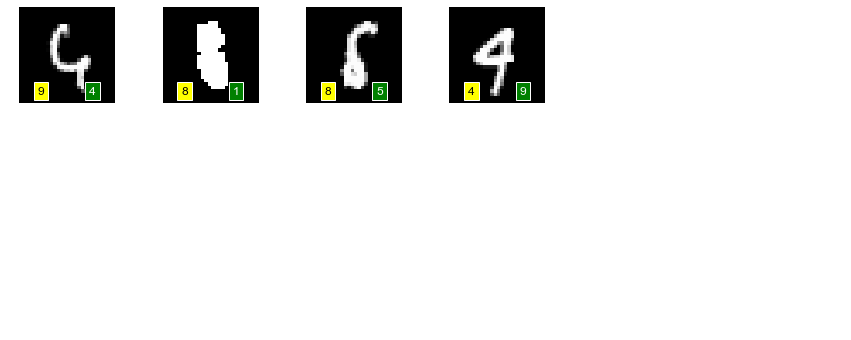

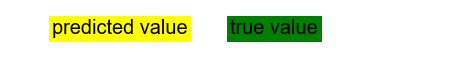

In [116]:
# Display some error results  (I updated a good function presented on Kaggle)

# Errors are the difference between predicted labels and true labels

y_err = [i for i in range(len(y_pred_classes)) if y_pred_classes[i]!=y_true[i]]
print(y_err) #indices of the mis-classifications

fig=plt.figure(figsize=(15, 6))
columns = 6
rows = 3
x=0
for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        if x<len(y_err):
            img_err = X_val[y_err[x]]
            predicted_value ='%1.0f'%(y_pred_classes[y_err[x]])
            plt.text(5, 25,predicted_value,color='black',fontsize=12,bbox=dict(facecolor='yellow'))
            true_value ='%1.0f'%(y_true[y_err[x]])
            plt.text(20, 25,true_value,color='white',fontsize=12,bbox=dict(facecolor='green'))
            plt.imshow(np.squeeze(img_err,axis=2), cmap="gray")
        x=x+1
    
fig=plt.figure(figsize=(8,1))

ax=fig.add_subplot()
ax.axis('off')
plt.text(0.1, 0.5,'predicted value',color='black',fontsize=20,bbox=dict(facecolor='yellow'))
plt.text(0.5, 0.5,'true value',color='black',fontsize=20,bbox=dict(facecolor='green'))

## Visualising Convolution Layers

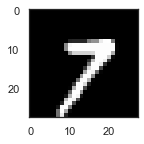

Output for each filter of the first Convolution Layer


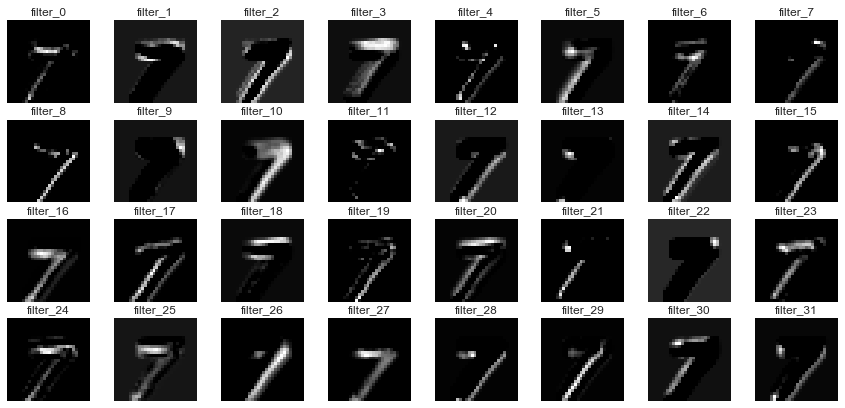

Output for each filter of the second Convolution Layer


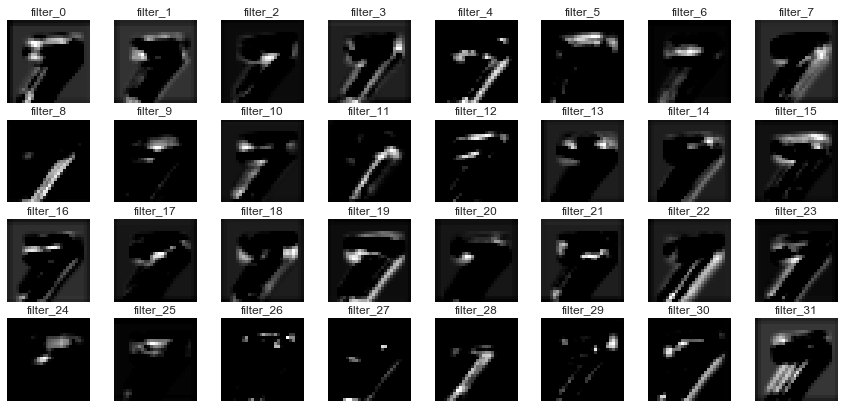

Output for each filter of the forth Convolution Layer


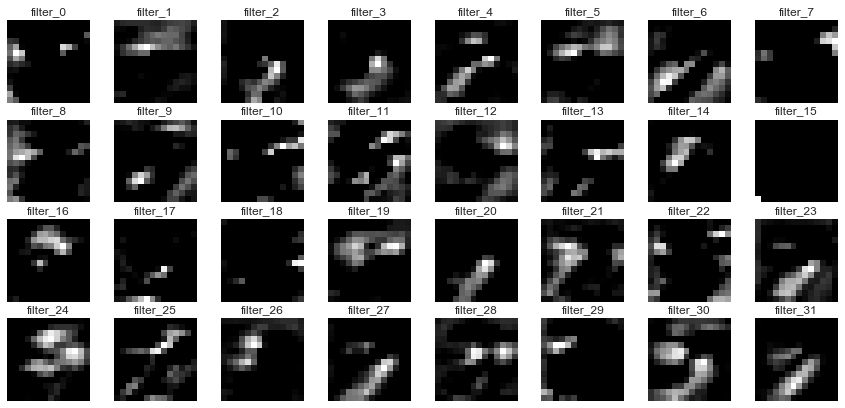

In [117]:
gig=plt.figure(figsize=(2,2))
img=X_val[8]
plt.imshow(np.squeeze(img,axis=2),cmap='gray')
plt.show()

img = np.expand_dims(img, axis=0)
conv1_output=Model(inputs=model.input,outputs=model.get_layer('conv2d_1').output)
conv2_output=Model(inputs=model.input,outputs=model.get_layer('conv2d_2').output)
conv3_output=Model(inputs=model.input,outputs=model.get_layer('conv2d_4').output)

conv1_features=conv1_output.predict(img)
conv2_features=conv2_output.predict(img)
conv3_features=conv3_output.predict(img)



fig=plt.figure(figsize=(15,7))
print("Output for each filter of the first Convolution Layer")
cols=8
rows=4
for i in range (cols*rows):
    fig.add_subplot(rows,cols,i+1)
    plt.axis('off')
    plt.title('filter_'+str(i))
    plt.imshow(conv1_features[0,:,:,i],cmap='gray')
plt.show()    


fig=plt.figure(figsize=(15,7))
print("Output for each filter of the second Convolution Layer")
cols=8
rows=4
for i in range (cols*rows):
    fig.add_subplot(rows,cols,i+1)
    plt.axis('off')
    plt.title('filter_'+str(i))
    plt.imshow(conv2_features[0,:,:,i],cmap='gray')
plt.show()

fig=plt.figure(figsize=(15,7))
print("Output for each filter of the forth Convolution Layer")
cols=8
rows=4
for i in range (cols*rows):
    fig.add_subplot(rows,cols,i+1)
    plt.axis('off')
    plt.title('filter_'+str(i))
    plt.imshow(conv3_features[0,:,:,i],cmap='gray')
plt.show()

# Prediction

In [118]:
results=model.predict(test)

In [119]:
# select the index with the maximum probability to decode the OHE coded results
results=np.argmax(results,axis=1)

In [120]:
#Proper format for output submission
results = pd.Series(results,name="Label")
labels=pd.Series(range(1,28001),name = "ImageId")
submission = pd.concat([labels,results],axis = 1)
submission.to_csv("MNIST_Recognizer_CNN.csv",index=False)